In [56]:
import psycopg2
import pandas as pd

# YOUR Redshift Serverless connection details
REDSHIFT_ENDPOINT = 'da226-nyc-workgroup.023381192327.us-east-1.redshift-serverless.amazonaws.com' 
REDSHIFT_PORT = '5439'
REDSHIFT_DB = 'dev'  # or 'nyc_dwh' - check your namespace
REDSHIFT_USER = 'admin-226'  # your admin username
REDSHIFT_PASSWORD = 'Data_226'  # your password

# Test connection
try:
    conn = psycopg2.connect(
          host=REDSHIFT_ENDPOINT,
          port=REDSHIFT_PORT,
          dbname=REDSHIFT_DB,
          user=REDSHIFT_USER,
          password=REDSHIFT_PASSWORD
      )
    print("✓ Connected to Redshift Serverless successfully!")

# Test query
    cursor = conn.cursor()
    cursor.execute("SELECT current_database(), current_user;")
    result = cursor.fetchone()
    print(f"✓ Database: {result[0]}")
    print(f"✓ User: {result[1]}")

    cursor.close()


except Exception as e:
    print(f" Connectionfailed:")
    print(f"Error: {e}")

✓ Connected to Redshift Serverless successfully!
✓ Database: dev
✓ User: admin-226


In [18]:
query = """
  SELECT 
      table_name,
      'Table exists' as status
  FROM information_schema.tables 
  WHERE table_schema = 'public'
  ORDER BY table_name;
  """

df_tables = pd.read_sql(query, conn)
print("Available tables:")
print(df_tables)

Available tables:
              table_name        status
0         dim_311_agency  Table exists
1        dim_311_borough  Table exists
2      dim_311_complaint  Table exists
3       dim_311_location  Table exists
4        dim_airbnb_date  Table exists
5        dim_airbnb_host  Table exists
6    dim_airbnb_location  Table exists
7    dim_airbnb_property  Table exists
8               dim_date  Table exists
9     fact_311_complaint  Table exists
10  fact_airbnb_listings  Table exists


/tmp/ipykernel_13939/2050003344.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tables = pd.read_sql(query, conn)


Available tables:
           table_name       status
      dim_311_agency Table exists
     dim_311_borough Table exists
   dim_311_complaint Table exists
    dim_311_location Table exists
     dim_airbnb_date Table exists
     dim_airbnb_host Table exists
 dim_airbnb_location Table exists
 dim_airbnb_property Table exists
            dim_date Table exists
  fact_311_complaint Table exists
fact_airbnb_listings Table exists


/tmp/ipykernel_13939/1430718785.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)
/tmp/ipykernel_13939/1430718785.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


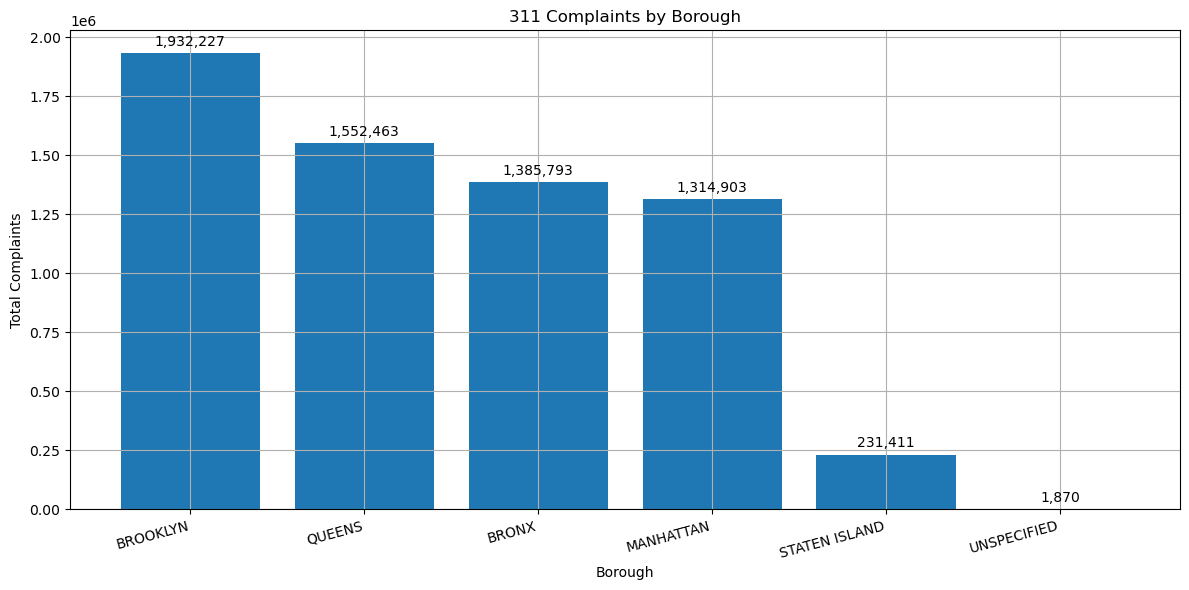

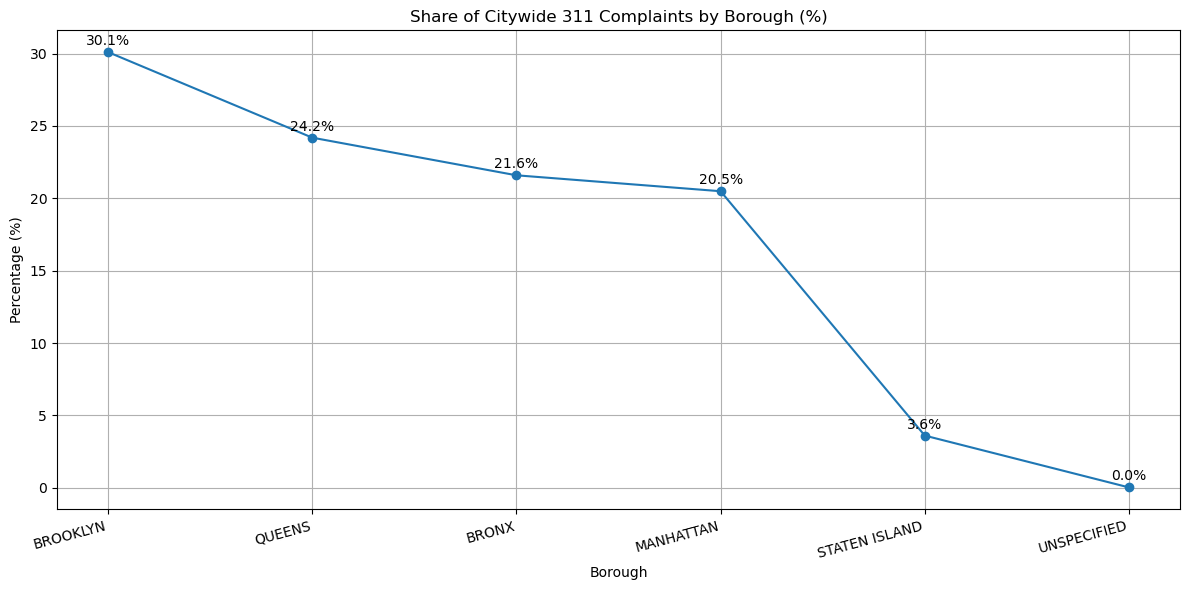

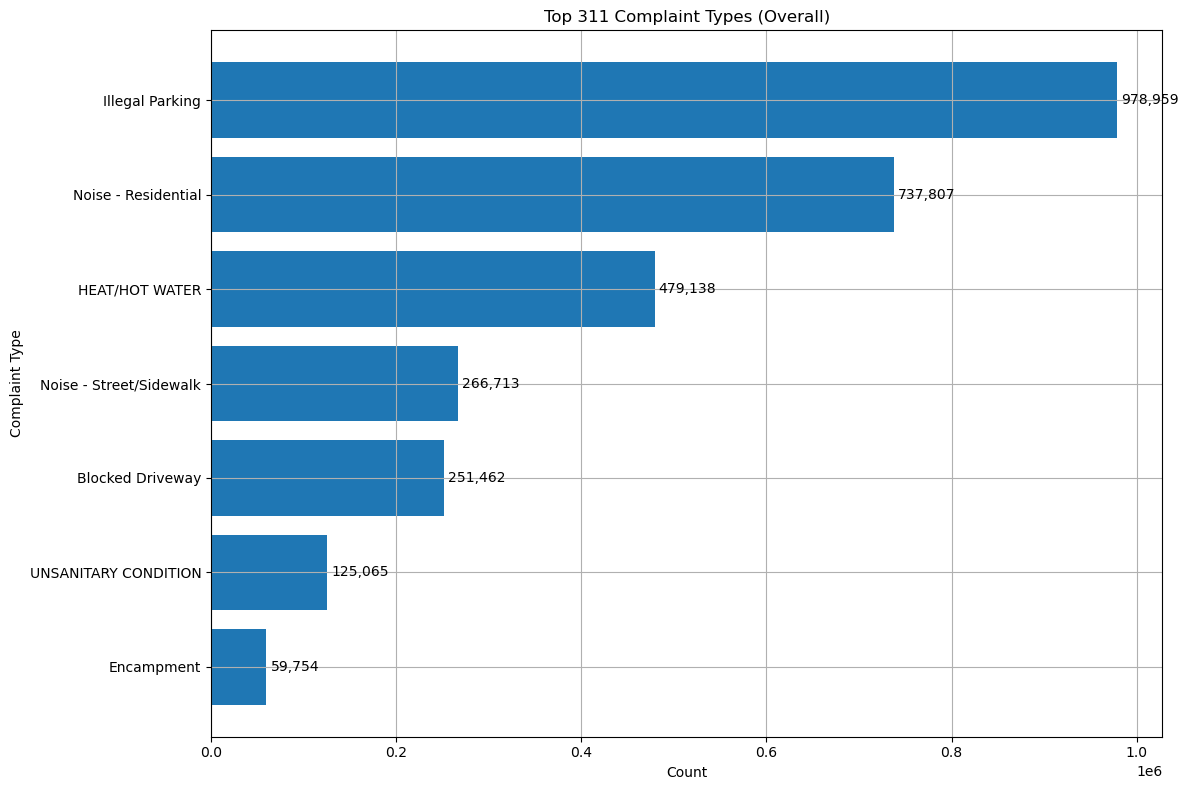

/tmp/ipykernel_13939/1430718785.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


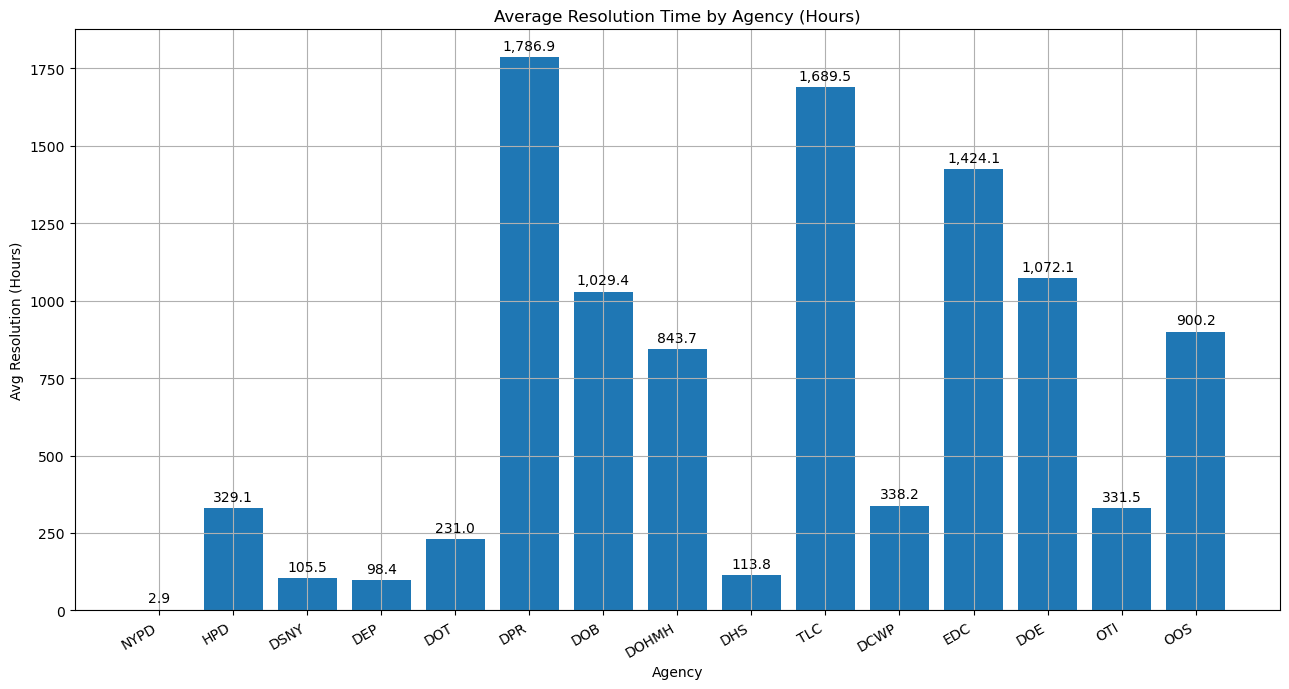

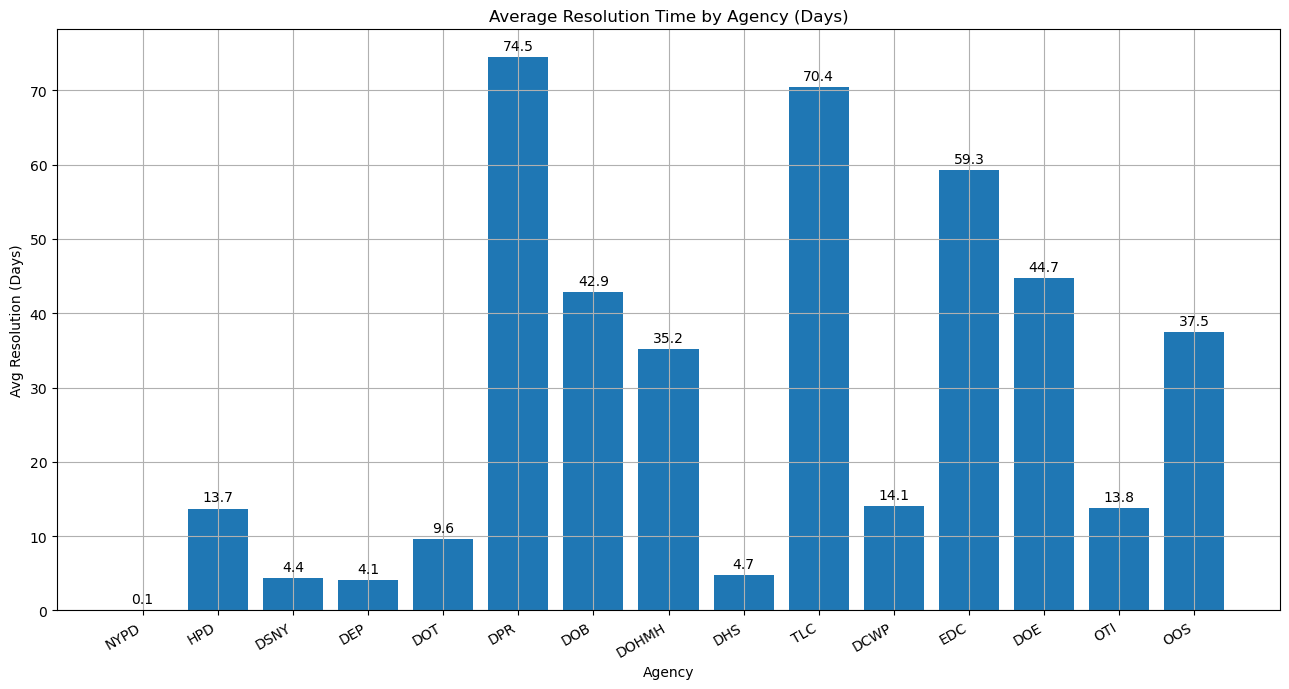

In [12]:
# ------------------------------------------------------------
# Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)  # comfy default size
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.which"] = "both"

# ------------------------------------------------------------
# Helper: run a SQL query into a pandas DataFrame
# ------------------------------------------------------------
def run_query(sql: str, conn) -> pd.DataFrame:
    return pd.read_sql(sql, conn)

# ------------------------------------------------------------
# Helper: draw value labels on bars (top/side depending on orientation)
# ------------------------------------------------------------
def label_bars(ax, fmt="{:,.0f}", offset=3, horizontal=False):
    if horizontal:
        for p in ax.patches:
            width = p.get_width()
            y = p.get_y() + p.get_height() / 2
            ax.annotate(fmt.format(width), (width, y),
                        xytext=(offset, 0), textcoords="offset points",
                        va="center", ha="left")
    else:
        for p in ax.patches:
            height = p.get_height()
            x = p.get_x() + p.get_width() / 2
            ax.annotate(fmt.format(height), (x, height),
                        xytext=(0, offset), textcoords="offset points",
                        va="bottom", ha="center")

# ------------------------------------------------------------
# (0) Inspect: list available tables (like your sample)
# ------------------------------------------------------------
tables_sql = """
  SELECT 
      table_name,
      'Table exists' AS status
  FROM information_schema.tables 
  WHERE table_schema = 'public'
  ORDER BY table_name;
"""
df_tables = run_query(tables_sql, conn)
print("Available tables:\n", df_tables.to_string(index=False))

# ============================================================
# (1) Complaints by borough (count + percentage)
# ============================================================
sql_borough = """
SELECT
    b.borough_name AS borough,
    COUNT(*) AS total_complaints,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) AS percentage
FROM public.fact_311_complaint f
JOIN public.dim_311_location l ON f.location_key = l.location_key
JOIN public.dim_311_borough  b ON l.borough = b.borough_name
GROUP BY b.borough_name
ORDER BY total_complaints DESC;
"""
df_borough = run_query(sql_borough, conn)

# Bar chart: total complaints by borough
fig1, ax1 = plt.subplots()
df_borough_sorted = df_borough.sort_values("total_complaints", ascending=False)
ax1.bar(df_borough_sorted["borough"], df_borough_sorted["total_complaints"])
ax1.set_title("311 Complaints by Borough")
ax1.set_xlabel("Borough")
ax1.set_ylabel("Total Complaints")
plt.xticks(rotation=15, ha="right")
label_bars(ax1, fmt="{:,.0f}")
plt.tight_layout()
plt.show()

# Pareto-style line for percentage (separate plot to keep one chart per figure)
fig1b, ax1b = plt.subplots()
ax1b.plot(df_borough_sorted["borough"], df_borough_sorted["percentage"], marker="o")
ax1b.set_title("Share of Citywide 311 Complaints by Borough (%)")
ax1b.set_xlabel("Borough")
ax1b.set_ylabel("Percentage (%)")
plt.xticks(rotation=15, ha="right")
for x, y in zip(df_borough_sorted["borough"], df_borough_sorted["percentage"]):
    ax1b.annotate(f"{y:.1f}%", (x, y), textcoords="offset points", xytext=(0, 5), ha="center")
plt.tight_layout()
plt.show()

# ============================================================
# (2) Top complaint types (overall + by borough raw)
# ============================================================
sql_types_by_borough = """
SELECT
    c.complaint_type,
    b.borough_name AS borough,
    COUNT(*) AS complaint_count
FROM public.fact_311_complaint f
JOIN public.dim_311_complaint c ON f.complaint_type_key = c.complaint_type_key
JOIN public.dim_311_location  l ON f.location_key       = l.location_key
JOIN public.dim_311_borough   b ON l.borough = b.borough_name
WHERE c.complaint_type IS NOT NULL
GROUP BY c.complaint_type, b.borough_name
ORDER BY complaint_count DESC
LIMIT 20;
"""
df_types_by_borough = run_query(sql_types_by_borough, conn)

# For a clean chart, aggregate the returned rows by complaint_type (across boroughs)
df_types_overall = (df_types_by_borough
                    .groupby("complaint_type", as_index=False)["complaint_count"].sum()
                    .sort_values("complaint_count", ascending=False)
                    .head(15))

# Horizontal bar chart: top complaint types
fig2, ax2 = plt.subplots(figsize=(12, 8))
ax2.barh(df_types_overall["complaint_type"], df_types_overall["complaint_count"])
ax2.invert_yaxis()  # largest at top
ax2.set_title("Top 311 Complaint Types (Overall)")
ax2.set_xlabel("Count")
ax2.set_ylabel("Complaint Type")
label_bars(ax2, fmt="{:,.0f}", horizontal=True)
plt.tight_layout()
plt.show()

# ============================================================
# (3) Average resolution time by agency
# ============================================================
sql_agency = """
SELECT
    a.agency_name,
    COUNT(*) AS total_complaints,
    ROUND(AVG(f.duration_hours), 2) AS avg_resolution_hours,
    ROUND(AVG(f.duration_hours) / 24, 1) AS avg_resolution_days
FROM public.fact_311_complaint f
JOIN public.dim_311_agency a ON f.agency_key = a.agency_key
WHERE f.duration_hours IS NOT NULL
GROUP BY a.agency_name
ORDER BY total_complaints DESC;
"""
df_agency = run_query(sql_agency, conn)

# Bar chart: avg resolution hours by agency (sorted by total complaints, show value labels in hours)
fig3, ax3 = plt.subplots(figsize=(13, 7))
df_agency_sorted = df_agency.sort_values(["total_complaints", "avg_resolution_hours"], ascending=[False, False])
ax3.bar(df_agency_sorted["agency_name"], df_agency_sorted["avg_resolution_hours"])
ax3.set_title("Average Resolution Time by Agency (Hours)")
ax3.set_xlabel("Agency")
ax3.set_ylabel("Avg Resolution (Hours)")
plt.xticks(rotation=30, ha="right")
label_bars(ax3, fmt="{:,.1f}")
plt.tight_layout()
plt.show()

# Optional: days view (separate figure)
fig3b, ax3b = plt.subplots(figsize=(13, 7))
ax3b.bar(df_agency_sorted["agency_name"], df_agency_sorted["avg_resolution_days"])
ax3b.set_title("Average Resolution Time by Agency (Days)")
ax3b.set_xlabel("Agency")
ax3b.set_ylabel("Avg Resolution (Days)")
plt.xticks(rotation=30, ha="right")
label_bars(ax3b, fmt="{:,.1f}")
plt.tight_layout()
plt.show()



/tmp/ipykernel_13939/4153138045.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)
/tmp/ipykernel_13939/4153138045.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


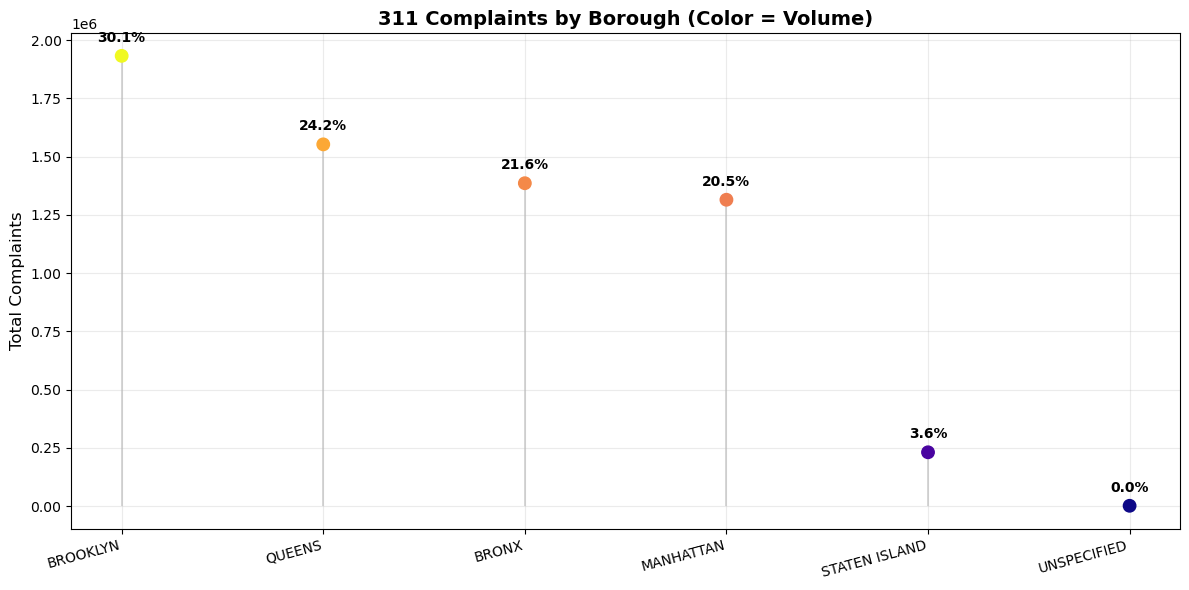

/tmp/ipykernel_13939/4153138045.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


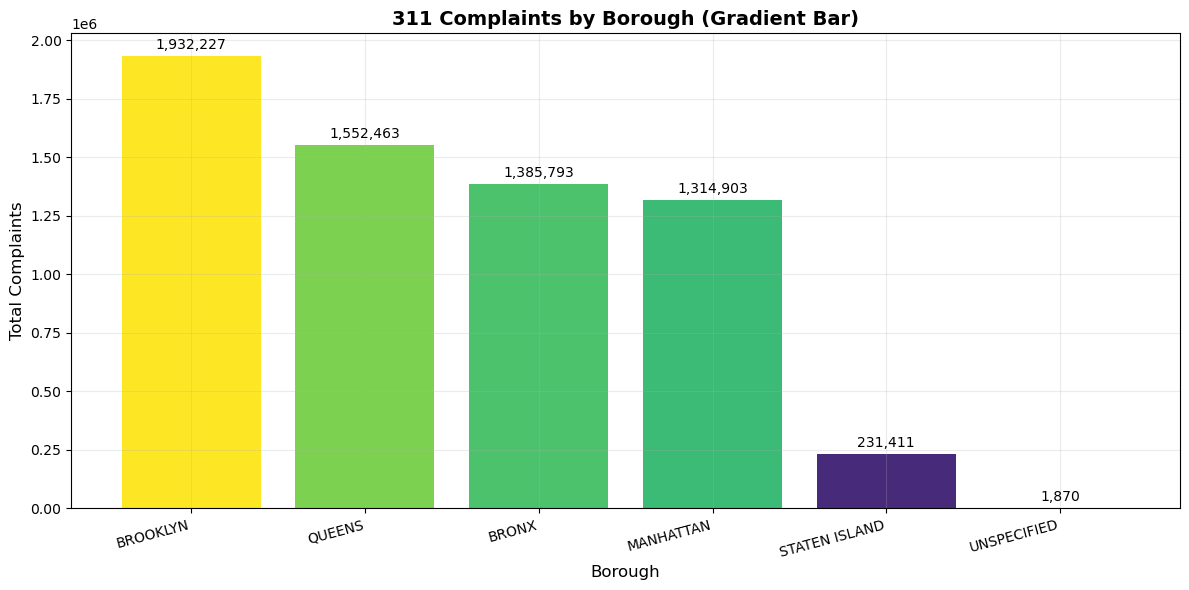

/tmp/ipykernel_13939/4153138045.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


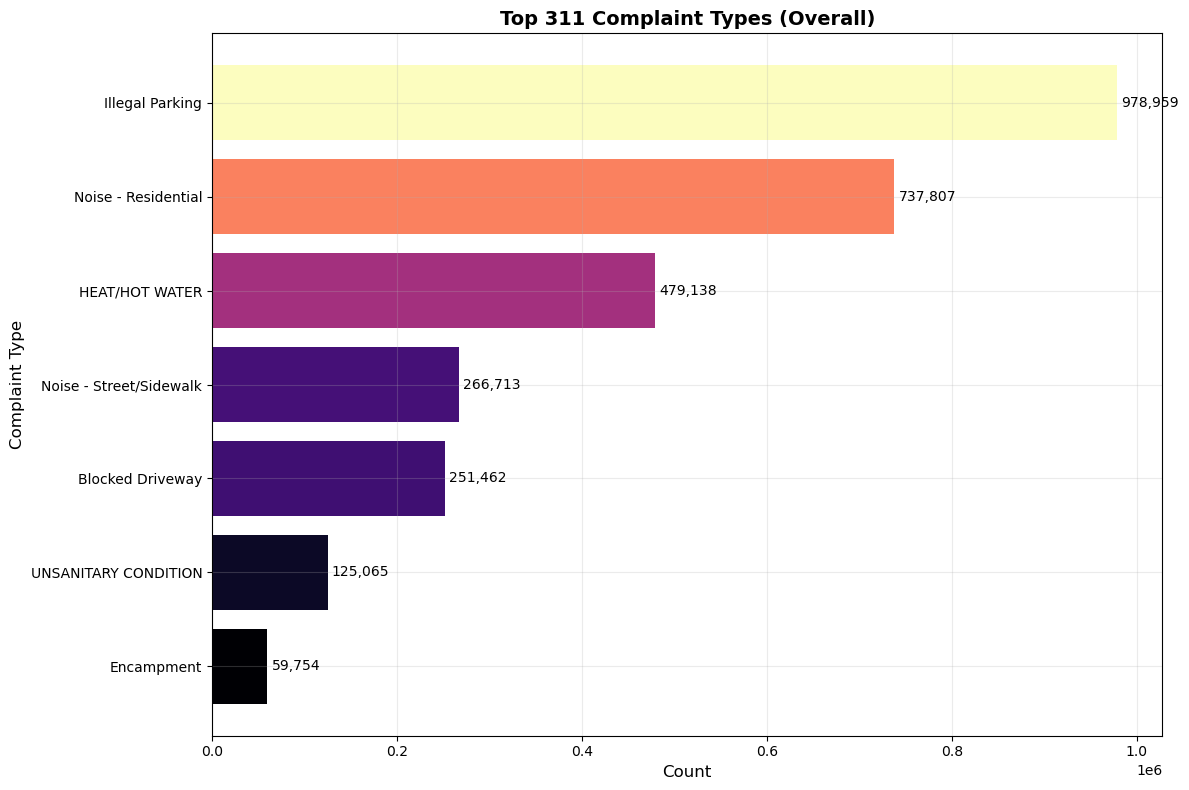

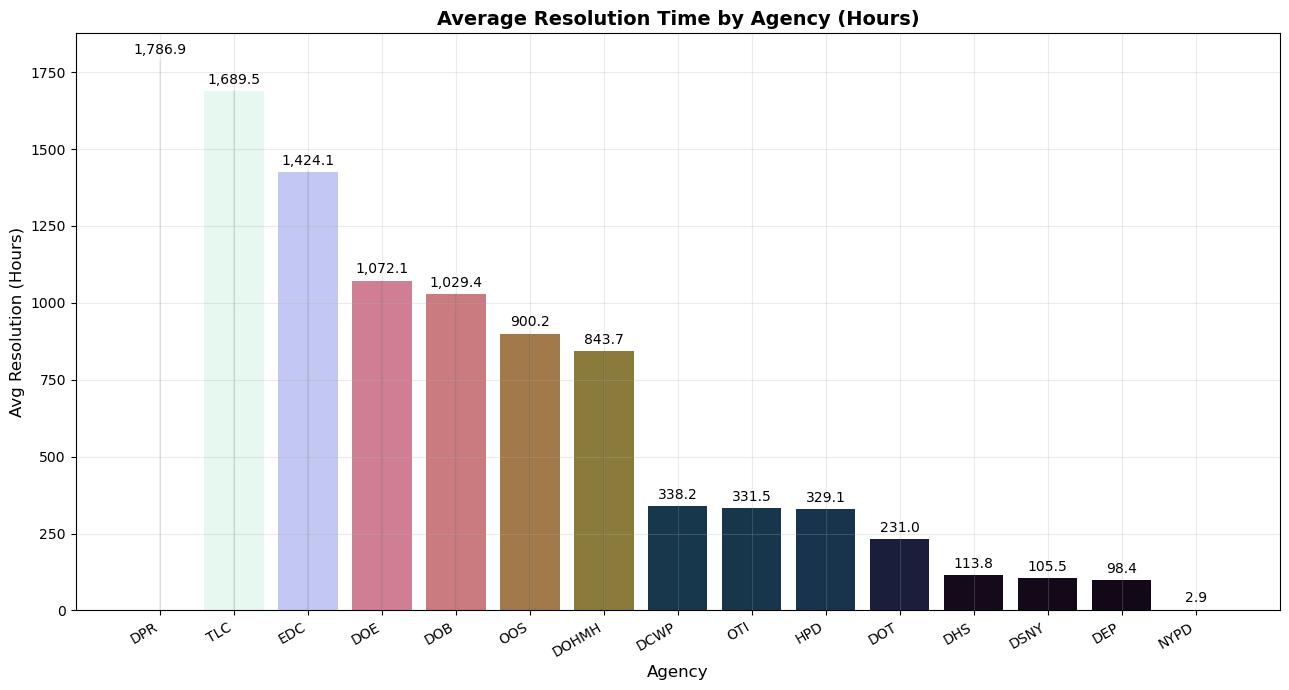

In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from textwrap import fill

plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.grid": True,
    "axes.grid.which": "both",
    "grid.alpha": 0.25,
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# ---------- Helpers ----------
def run_query(sql: str, conn) -> pd.DataFrame:
    return pd.read_sql(sql, conn)

def wrap_labels(labels, width=22):
    return [fill(str(x), width=width) for x in labels]

def color_by_value(series, cmap_name="viridis", vmin=None, vmax=None):
    """
    Map a numeric Series to RGBA colors using a colormap.
    """
    vals = series.to_numpy(dtype=float)
    if vmin is None: vmin = np.nanmin(vals)
    if vmax is None: vmax = np.nanmax(vals)
    norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    cmap = cm.get_cmap(cmap_name)
    return cmap(norm(vals))

def add_bar_labels(ax, fmt="{:,.0f}", rotation=0, offset=3, horizontal=False):
    if horizontal:
        for p in ax.patches:
            width = p.get_width()
            y = p.get_y() + p.get_height()/2
            ax.annotate(fmt.format(width),
                        (width, y),
                        xytext=(offset, 0),
                        textcoords="offset points",
                        va="center", ha="left")
    else:
        for p in ax.patches:
            height = p.get_height()
            x = p.get_x() + p.get_width()/2
            ax.annotate(fmt.format(height),
                        (x, height),
                        xytext=(0, offset),
                        textcoords="offset points",
                        va="bottom", ha="center", rotation=rotation)

def lollipop(ax, x, y, color_line="#999999", colors_points=None):
    """
    Vertical lollipop chart (nice for ranked items).
    """
    ax.vlines(x=x, ymin=0, ymax=y, color=color_line, linewidth=1.2, alpha=0.7)
    if colors_points is None:
        ax.scatter(x, y, s=80, zorder=3)
    else:
        ax.scatter(x, y, s=80, c=colors_points, zorder=3)

# ---------- SQL ----------
sql_borough = """
SELECT
    b.borough_name AS borough,
    COUNT(*) AS total_complaints,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) AS percentage
FROM public.fact_311_complaint f
JOIN public.dim_311_location l ON f.location_key = l.location_key
JOIN public.dim_311_borough  b ON l.borough = b.borough_name
GROUP BY b.borough_name
ORDER BY total_complaints DESC;
"""

sql_types_by_borough = """
SELECT
    c.complaint_type,
    b.borough_name AS borough,
    COUNT(*) AS complaint_count
FROM public.fact_311_complaint f
JOIN public.dim_311_complaint c ON f.complaint_type_key = c.complaint_type_key
JOIN public.dim_311_location  l ON f.location_key       = l.location_key
JOIN public.dim_311_borough   b ON l.borough            = b.borough_name
WHERE c.complaint_type IS NOT NULL
GROUP BY c.complaint_type, b.borough_name
ORDER BY complaint_count DESC
LIMIT 20;
"""

sql_agency = """
SELECT
    a.agency_name,
    COUNT(*) AS total_complaints,
    ROUND(AVG(f.duration_hours), 2) AS avg_resolution_hours,
    ROUND(AVG(f.duration_hours) / 24, 1) AS avg_resolution_days
FROM public.fact_311_complaint f
JOIN public.dim_311_agency a ON f.agency_key = a.agency_key
WHERE f.duration_hours IS NOT NULL
GROUP BY a.agency_name
ORDER BY total_complaints DESC;
"""

# ---------- Fetch ----------
df_borough = run_query(sql_borough, conn)
df_types_raw = run_query(sql_types_by_borough, conn)
df_agency = run_query(sql_agency, conn)

# ---------- (1) Complaints by Borough: vibrant lollipop + % labels ----------
df_bor = df_borough.sort_values("total_complaints", ascending=False).reset_index(drop=True)
x = np.arange(len(df_bor))
y = df_bor["total_complaints"].values
colors_pts = color_by_value(df_bor["total_complaints"], cmap_name="plasma")

fig1, ax1 = plt.subplots()
lollipop(ax1, x, y, color_line="#bbbbbb", colors_points=colors_pts)
ax1.set_xticks(x)
ax1.set_xticklabels(df_bor["borough"], rotation=15, ha="right")
ax1.set_ylabel("Total Complaints")
ax1.set_title("311 Complaints by Borough (Color = Volume)")
# add percentage labels above points
for xi, yi, pct in zip(x, y, df_bor["percentage"]):
    ax1.annotate(f"{pct:.1f}%",
                 (xi, yi),
                 xytext=(0, 8),
                 textcoords="offset points",
                 ha="center", va="bottom", fontsize=10, fontweight="bold")
plt.tight_layout()
plt.show()

# ---------- (1b) Same data as a gradient bar (for reports) ----------
fig1b, ax1b = plt.subplots()
bar_colors = color_by_value(df_bor["total_complaints"], cmap_name="viridis")
bars = ax1b.bar(df_bor["borough"], df_bor["total_complaints"], color=bar_colors, edgecolor="none")
ax1b.set_title("311 Complaints by Borough (Gradient Bar)")
ax1b.set_xlabel("Borough")
ax1b.set_ylabel("Total Complaints")
plt.xticks(rotation=15, ha="right")
add_bar_labels(ax1b, fmt="{:,}")
plt.tight_layout()
plt.show()

# ---------- (2) Top Complaint Types: rich horizontal bars with smart wrap ----------
# Aggregate across boroughs for a clean “overall top” view
df_types = (df_types_raw.groupby("complaint_type", as_index=False)["complaint_count"]
            .sum()
            .sort_values("complaint_count", ascending=False)
            .head(15))
df_types["complaint_type_wrapped"] = wrap_labels(df_types["complaint_type"], width=28)
type_colors = color_by_value(df_types["complaint_count"], cmap_name="magma")

fig2, ax2 = plt.subplots(figsize=(12, 8))
ax2.barh(df_types["complaint_type_wrapped"], df_types["complaint_count"], color=type_colors)
ax2.invert_yaxis()
ax2.set_title("Top 311 Complaint Types (Overall)")
ax2.set_xlabel("Count")
ax2.set_ylabel("Complaint Type")
add_bar_labels(ax2, fmt="{:,}", horizontal=True)
plt.tight_layout()
plt.show()

# ---------- (3) Avg Resolution by Agency: color by hours, rank lines ----------
df_ag = df_agency.sort_values("avg_resolution_hours", ascending=False).reset_index(drop=True)
res_colors = color_by_value(df_ag["avg_resolution_hours"], cmap_name="cubehelix")

fig3, ax3 = plt.subplots(figsize=(13, 7))
bars = ax3.bar(df_ag["agency_name"], df_ag["avg_resolution_hours"], color=res_colors)
ax3.set_title("Average Resolution Time by Agency (Hours)")
ax3.set_xlabel("Agency")
ax3.set_ylabel("Avg Resolution (Hours)")
plt.xticks(rotation=30, ha="right")
add_bar_labels(ax3, fmt="{:,.1f}")
# subtle rank lines
for i, p in enumerate(bars):
    ax3.plot([p.get_x()+p.get_width()/2, p.get_x()+p.get_width()/2],
             [0, p.get_height()], color="k", alpha=0.06)
plt.tight_layout()
plt.show()

# ---------- (Optional) Save high-DPI images ----------
# fig1.savefig("311_borough_lollipop.png", dpi=240, bbox_inches="tight")
# fig1b.savefig("311_borough_gradient_bar.png", dpi=240, bbox_inches="tight")
# fig2.savefig("311_top_types.png", dpi=260, bbox_inches="tight")
# fig3.savefig("311_avg_resolution_agency.png", dpi=260, bbox_inches="tight")


/tmp/ipykernel_13939/1036873983.py:58: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_correlation = pd.read_sql(query_correlation, conn)



Loaded 1081 geohash6 regions for correlation analysis
  borough  complaint_count  airbnb_count
MANHATTAN            24140           694
MANHATTAN            20788           621
MANHATTAN            23454           467
MANHATTAN            13252           452
MANHATTAN            20211           421
MANHATTAN            16196           378
MANHATTAN            28165           367
MANHATTAN            13426           351
MANHATTAN            22142           348
MANHATTAN            11701           348

Pearson Correlation: 0.4330
P-value: 0.000000
Interpretation: Statistically significant


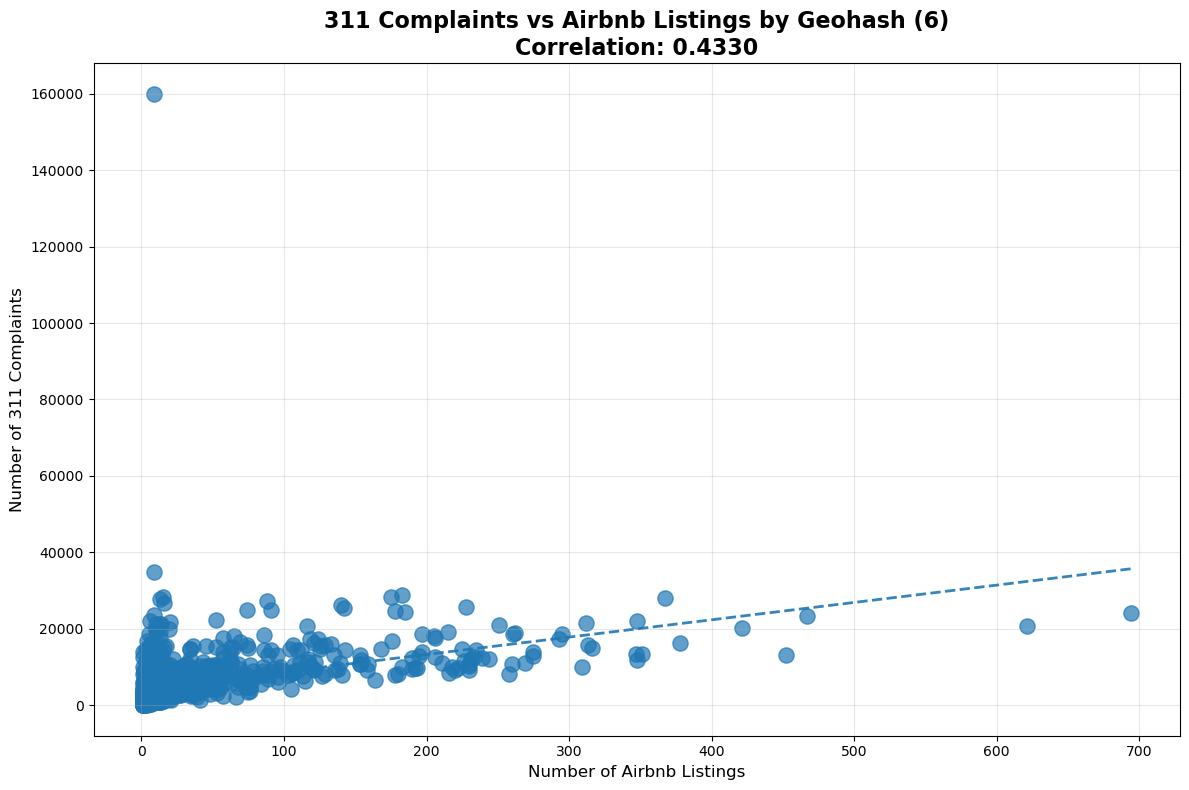

In [23]:
# Cell: 311 Complaints vs Airbnb by Borough
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


query_correlation = """
WITH complaints AS (
  SELECT 
      LEFT(f311.geohash, 6) AS g6,
      COUNT(DISTINCT f311.complaint_id) AS complaint_count
  FROM public.fact_311_complaint AS f311
  WHERE f311.geohash IS NOT NULL
  GROUP BY LEFT(f311.geohash, 6)
),
airbnb AS (
  SELECT 
      LEFT(fa.geohash, 6) AS g6,
      COUNT(DISTINCT fa.listing_id) AS airbnb_count
  FROM public.fact_airbnb_listings AS fa
  WHERE fa.geohash IS NOT NULL
  GROUP BY LEFT(fa.geohash, 6)
),
boro_ct AS (
  SELECT 
      LEFT(d311.geohash, 6) AS g6,
      UPPER(TRIM(d311.borough)) AS borough,
      COUNT(*) AS n
  FROM public.dim_311_location AS d311
  WHERE d311.geohash IS NOT NULL 
    AND d311.borough IS NOT NULL
  GROUP BY LEFT(d311.geohash, 6), UPPER(TRIM(d311.borough))
),
borough_map AS (
  SELECT g6, borough
  FROM (
    SELECT 
        g6, borough,
        ROW_NUMBER() OVER (PARTITION BY g6 ORDER BY n DESC) AS rn
    FROM boro_ct
  ) x
  WHERE rn = 1
)
SELECT 
    COALESCE(bm.borough, 'UNKNOWN') AS borough,
    c.complaint_count,
    a.airbnb_count
FROM complaints AS c
JOIN airbnb AS a USING (g6)
LEFT JOIN borough_map AS bm USING (g6)
WHERE a.airbnb_count > 0 
  AND c.complaint_count > 0
ORDER BY airbnb_count DESC;

"""

df_correlation = pd.read_sql(query_correlation, conn)
print(f"\nLoaded {len(df_correlation)} geohash6 regions for correlation analysis")
print(df_correlation.head(10).to_string(index=False))

# Guard against too few rows
if len(df_correlation) < 2:
    print("\nNot enough data points to calculate correlation (need at least 2).")
else:
    correlation, p_value = pearsonr(df_correlation['airbnb_count'],
                                    df_correlation['complaint_count'])
    print(f"\n{'='*60}")
    print(f"Pearson Correlation: {correlation:.4f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Interpretation: {'Statistically significant' if p_value < 0.05 else 'Not significant'}")
    print(f"{'='*60}")

    # Plot
    plt.figure(figsize=(12, 8))
    plt.scatter(df_correlation['airbnb_count'], df_correlation['complaint_count'],
                alpha=0.7, s=120)

    plt.title(f'311 Complaints vs Airbnb Listings by Geohash (6)\nCorrelation: {correlation:.4f}',
              fontsize=16, fontweight='bold')
    plt.xlabel('Number of Airbnb Listings', fontsize=12)
    plt.ylabel('Number of 311 Complaints', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Trend line
    z = np.polyfit(df_correlation['airbnb_count'], df_correlation['complaint_count'], 1)
    p = np.poly1d(z)
    plt.plot(df_correlation['airbnb_count'], p(df_correlation['airbnb_count']), "--", alpha=0.9, linewidth=2)

    plt.tight_layout()
    plt.show()


In [27]:
query_borough = """
WITH complaints AS (
  SELECT 
      UPPER(TRIM(d311.borough)) AS borough,
      COUNT(DISTINCT f311.complaint_id) AS complaint_count
  FROM public.fact_311_complaint AS f311
  JOIN public.dim_311_location AS d311
    ON f311.location_key = d311.location_key
  WHERE d311.borough IS NOT NULL
  GROUP BY UPPER(TRIM(d311.borough))
),
airbnb AS (
  SELECT 
      UPPER(TRIM(da.borough)) AS borough,
      COUNT(DISTINCT fa.listing_id) AS airbnb_count
  FROM public.fact_airbnb_listings AS fa
  JOIN public.dim_airbnb_location AS da
    ON fa.geohash = da.geohash
  WHERE da.borough IS NOT NULL
  GROUP BY UPPER(TRIM(da.borough))
)
SELECT 
    c.borough,
    c.complaint_count,
    a.airbnb_count
FROM complaints AS c
JOIN airbnb AS a 
  ON a.borough = c.borough
WHERE a.airbnb_count > 0 
  AND c.complaint_count > 0
ORDER BY a.airbnb_count DESC;
"""

df = pd.read_sql(query_borough, conn)

# --- Show results ---
if df.empty:
    print("⚠️ No data returned — check borough values or geohash consistency.")
else:
    print(f"✅ Loaded {len(df)} boroughs for correlation analysis")
    print(df.to_string(index=False))


/tmp/ipykernel_13939/106230582.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query_borough, conn)


✅ Loaded 5 boroughs for correlation analysis
      borough  complaint_count  airbnb_count
    MANHATTAN          1314903         16081
     BROOKLYN          1932227         13251
       QUEENS          1552463          5323
        BRONX          1385793          1121
STATEN ISLAND           231411           366


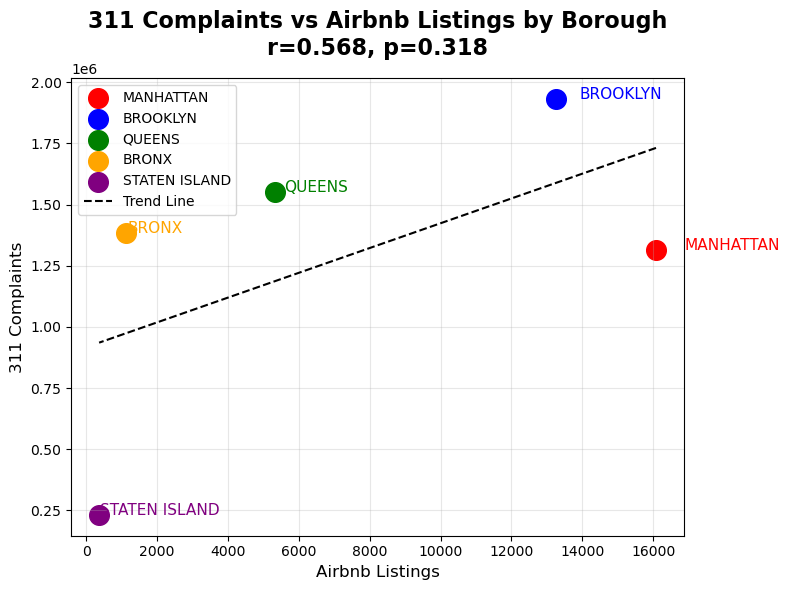

In [30]:
from scipy.stats import pearsonr
import numpy as np

plt.figure(figsize=(8, 6))
colors = {'MANHATTAN':'red','BROOKLYN':'blue','QUEENS':'green','BRONX':'orange','STATEN ISLAND':'purple'}

for _, row in df.iterrows():
    plt.scatter(row['airbnb_count'], row['complaint_count'], s=200, color=colors[row['borough']], label=row['borough'])
    plt.text(row['airbnb_count']*1.05, row['complaint_count'], row['borough'], fontsize=11, color=colors[row['borough']])

# Trend line
z = np.polyfit(df['airbnb_count'], df['complaint_count'], 1)
p = np.poly1d(z)
plt.plot(df['airbnb_count'], p(df['airbnb_count']), 'k--', label='Trend Line')

# Correlation
r, pval = pearsonr(df['airbnb_count'], df['complaint_count'])
plt.title(f"311 Complaints vs Airbnb Listings by Borough\nr={r:.3f}, p={pval:.3f}", fontsize=16, fontweight='bold')
plt.xlabel("Airbnb Listings", fontsize=12)
plt.ylabel("311 Complaints", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


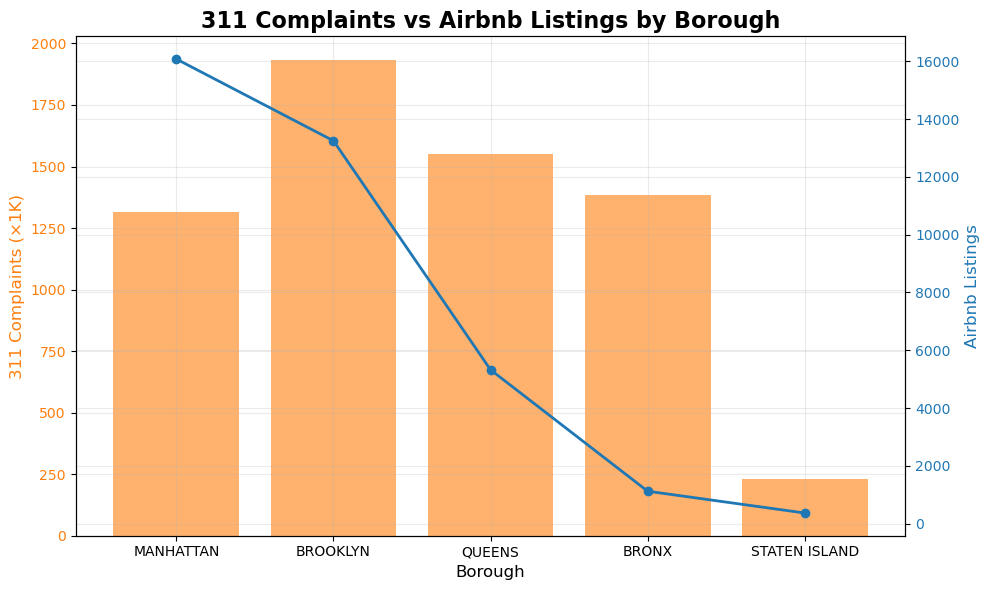

In [36]:
fig, ax1 = plt.subplots(figsize=(10,6))

color1 = 'tab:orange'
ax1.set_xlabel('Borough')
ax1.set_ylabel('311 Complaints (×1K)', color=color1)
ax1.bar(df['borough'], df['complaint_count'] / 1000, color=color1, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Airbnb Listings', color=color2)
ax2.plot(df['borough'], df['airbnb_count'], color=color2, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("311 Complaints vs Airbnb Listings by Borough", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


/tmp/ipykernel_13939/891536045.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_neigh = pd.read_sql(query, conn)


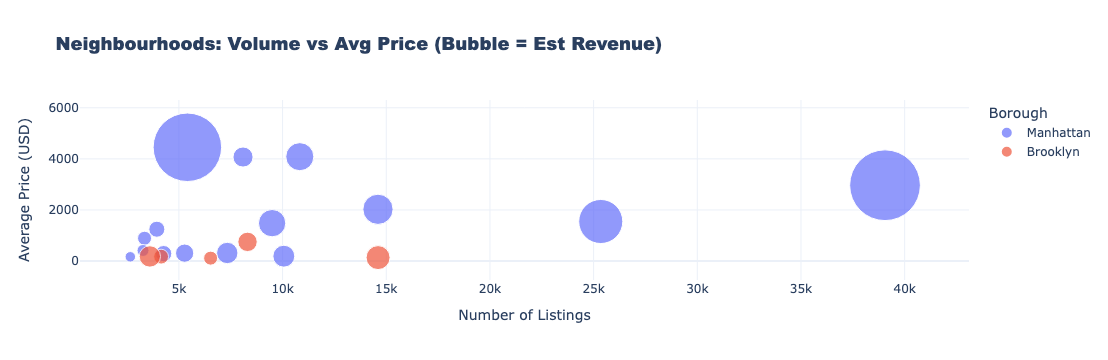

In [46]:
import pandas as pd
import plotly.express as px

# --- Run SQL to fetch top neighbourhoods ---
query = """
SELECT
    al.neighbourhood_name AS neighbourhood,
    al.borough,
    COUNT(*) AS listings,
    ROUND(AVG(TRY_CAST(f.price AS DECIMAL(18,2))), 2) AS avg_price,
    ROUND(SUM(TRY_CAST(f.estimated_revenue_l365d AS DECIMAL(18,2))), 0) AS est_total_revenue_l365d
FROM public.fact_airbnb_listings f
JOIN public.dim_airbnb_location al
  ON f.geohash = al.geohash
WHERE f.price NOT IN ('NaN', 'nan', '', 'INF', '-INF')
  AND TRY_CAST(f.price AS DECIMAL(18,2)) IS NOT NULL
GROUP BY al.neighbourhood_name, al.borough
ORDER BY listings DESC
LIMIT 20;
"""

df_neigh = pd.read_sql(query, conn)

# --- Interactive bubble scatter chart ---
fig = px.scatter(
    df_neigh,
    x="listings", 
    y="avg_price",
    size="est_total_revenue_l365d", 
    color="borough",
    hover_name="neighbourhood",
    title="Neighbourhoods: Volume vs Avg Price (Bubble = Est Revenue)",
    size_max=50,
)

fig.update_layout(
    xaxis_title="Number of Listings",
    yaxis_title="Average Price (USD)",
    template="plotly_white",
    title_font=dict(size=18, family="Arial Black"),
    legend_title_text="Borough"
)

fig.show()


In [42]:
conn.close()

/tmp/ipykernel_13939/1739430377.py:31: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



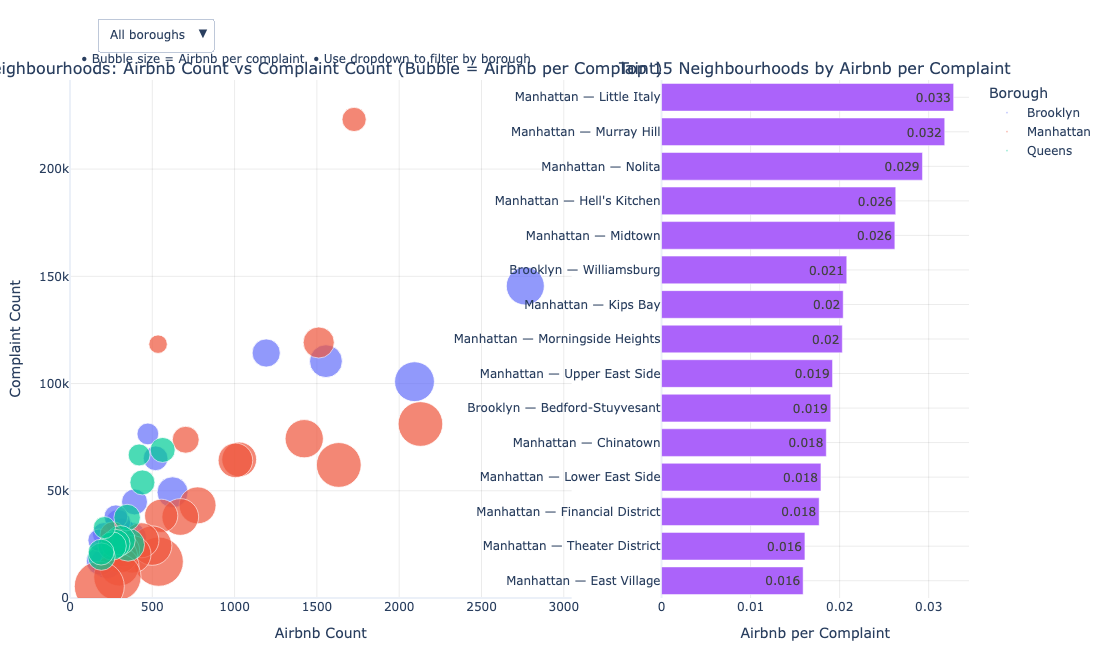

In [47]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- 1) Run your query -------------------------------------------------------
sql = """
SELECT
    al.borough,
    al.neighbourhood_name AS neighbourhood,
    COUNT(DISTINCT c.complaint_id) AS complaint_count,
    COUNT(DISTINCT f.listing_id)   AS airbnb_count,
    ROUND(
      COUNT(DISTINCT f.listing_id)::DECIMAL
      / NULLIF(COUNT(DISTINCT c.complaint_id), 0), 4
    ) AS airbnb_per_complaint
FROM public.dim_airbnb_location     al
LEFT JOIN public.fact_airbnb_listings f
  ON f.geohash = al.geohash
LEFT JOIN public.dim_311_location l311
  ON l311.geohash = al.geohash
LEFT JOIN public.fact_311_complaint c
  ON c.location_key = l311.location_key
WHERE al.borough IS NOT NULL
GROUP BY al.borough, al.neighbourhood_name
HAVING COUNT(DISTINCT c.complaint_id) > 10
ORDER BY airbnb_count DESC
LIMIT 50;
"""

df = pd.read_sql(sql, conn)

# ensure numeric
for col in ["complaint_count", "airbnb_count", "airbnb_per_complaint"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# clean any infs/nans from division (should be none due to HAVING, but guard)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["complaint_count","airbnb_count","airbnb_per_complaint"])

# --- 2) Prep sizing for bubbles ---------------------------------------------
# Plotly's area-based sizing uses sizeref ~ 2*max(size)/(desired_max_pixel^2)
desired_max_px = 50
sizeref = 2.0 * df["airbnb_per_complaint"].max() / (desired_max_px**2) if df["airbnb_per_complaint"].max() else 1

# --- 3) Build composite figure (scatter + ranking bar) ----------------------
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.62, 0.38],
    subplot_titles=(
        "Neighbourhoods: Airbnb Count vs Complaint Count (Bubble = Airbnb per Complaint)",
        "Top 15 Neighbourhoods by Airbnb per Complaint"
    )
)

# Create one scatter trace per borough so legend filters by borough
boroughs = df["borough"].dropna().unique()
scatter_traces = []
for b in sorted(boroughs):
    d = df[df["borough"] == b]
    sc = go.Scatter(
        x=d["airbnb_count"],
        y=d["complaint_count"],
        mode="markers",
        name=b,
        customdata=np.stack([d["neighbourhood"], d["airbnb_per_complaint"]], axis=-1),
        marker=dict(
            size=d["airbnb_per_complaint"], sizemode="area", sizeref=sizeref, sizemin=4,
            line=dict(width=0.8)
        ),
        hovertemplate=(
            "<b>%{customdata[0]}</b><br>"
            "Borough: %{fullData.name}<br>"
            "Airbnb count: %{x:,}<br>"
            "Complaint count: %{y:,}<br>"
            "Airbnb per complaint: %{customdata[1]:.3f}<extra></extra>"
        ),
        showlegend=True
    )
    fig.add_trace(sc, row=1, col=1)
    scatter_traces.append(sc)

# Right panel: Top 15 neighborhoods by ratio
top15 = df.sort_values("airbnb_per_complaint", ascending=False).head(15).iloc[::-1]  # reverse for horizontal bar
bar = go.Bar(
    x=top15["airbnb_per_complaint"],
    y=(top15["borough"] + " — " + top15["neighbourhood"]),
    orientation="h",
    text=top15["airbnb_per_complaint"].round(3),
    textposition="auto",
    hovertemplate=(
        "<b>%{y}</b><br>"
        "Airbnb per complaint: %{x:.3f}<br>"
        "Airbnb count: %{customdata[0]:,}<br>"
        "Complaint count: %{customdata[1]:,}<extra></extra>"
    ),
    customdata=np.stack([top15["airbnb_count"], top15["complaint_count"]], axis=-1),
    showlegend=False,
)
fig.add_trace(bar, row=1, col=2)

# --- 4) Borough filter buttons (show/hide) ----------------------------------
# Build updatemenus: "All" + one per borough
buttons = []

# All on
buttons.append(dict(
    label="All boroughs",
    method="update",
    args=[{"visible": [True]*len(boroughs) + [True]},  # all scatters + bar
          {"title": ("Neighbourhoods: Airbnb Count vs Complaint Count (Bubble = Airbnb per Complaint)")}]
))

# One per borough
for i, b in enumerate(sorted(boroughs)):
    vis = [False]*len(boroughs)
    vis[i] = True  # show only this borough scatter
    vis = vis + [True]  # keep the bar chart visible
    buttons.append(dict(
        label=b,
        method="update",
        args=[{"visible": vis},
              {"title": f"Neighbourhoods in {b}: Airbnb Count vs Complaint Count (Bubble = Airbnb per Complaint)"}]
    ))

fig.update_layout(
    updatemenus=[dict(
        type="dropdown",
        x=0.03, y=1.12, xanchor="left", yanchor="top",
        buttons=buttons,
        showactive=True
    )]
)

# --- 5) Layout polish --------------------------------------------------------
fig.update_xaxes(
    title_text="Airbnb Count",
    rangemode="tozero",
    gridcolor="rgba(0,0,0,0.08)",
    row=1, col=1
)
fig.update_yaxes(
    title_text="Complaint Count",
    rangemode="tozero",
    gridcolor="rgba(0,0,0,0.08)",
    row=1, col=1
)
fig.update_xaxes(
    title_text="Airbnb per Complaint",
    gridcolor="rgba(0,0,0,0.08)",
    row=1, col=2
)
fig.update_yaxes(
    title_text="",
    gridcolor="rgba(0,0,0,0.08)",
    row=1, col=2
)

fig.update_layout(
    height=650,
    title_font=dict(size=18),
    margin=dict(l=70, r=30, t=80, b=50),
    hovermode="closest",
    legend_title_text="Borough",
    template="plotly_white"
)

# helpful annotations
fig.add_annotation(
    xref="paper", yref="paper", x=0.01, y=1.06, showarrow=False,
    text="• Bubble size = Airbnb per complaint  • Use dropdown to filter by borough"
)

fig.show()


/tmp/ipykernel_13939/2547539603.py:48: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

/tmp/ipykernel_13939/2547539603.py:54: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/tmp/ipykernel_13939/2547539603.py:68: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



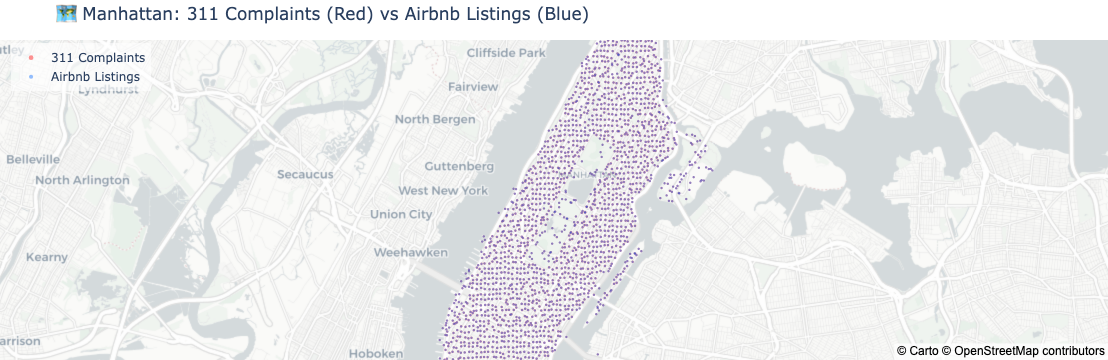

In [52]:
import pandas as pd
import plotly.graph_objects as go

# --- 1. Query only Manhattan data -------------------------------------------
sql = """
WITH complaints AS (
    SELECT
        l311.geohash,
        AVG(l311.latitude) AS latitude,
        AVG(l311.longitude) AS longitude,
        l311.borough,
        COUNT(*) AS complaint_count
    FROM public.fact_311_complaint f
    JOIN public.dim_311_location l311
      ON f.location_key = l311.location_key
    WHERE l311.borough ILIKE '%MANHATTAN%'
      AND l311.latitude IS NOT NULL AND l311.longitude IS NOT NULL
    GROUP BY l311.geohash, l311.borough
),
airbnb AS (
    SELECT
        al.geohash,
        AVG(al.latitude) AS latitude,
        AVG(al.longitude) AS longitude,
        al.borough,
        COUNT(*) AS listing_count
    FROM public.fact_airbnb_listings f
    JOIN public.dim_airbnb_location al
      ON f.geohash = al.geohash
    WHERE al.borough ILIKE '%MANHATTAN%'
      AND al.latitude IS NOT NULL AND al.longitude IS NOT NULL
    GROUP BY al.geohash, al.borough
)
SELECT
    COALESCE(a.latitude, c.latitude) AS latitude,
    COALESCE(a.longitude, c.longitude) AS longitude,
    COALESCE(a.borough, c.borough) AS borough,
    COALESCE(c.complaint_count, 0) AS complaint_count,
    COALESCE(a.listing_count, 0) AS listing_count
FROM complaints c
FULL OUTER JOIN airbnb a
  ON c.geohash = a.geohash
WHERE COALESCE(a.borough, c.borough) ILIKE '%MANHATTAN%';
"""

        

df = pd.read_sql(sql, conn)

# --- 2. Plot map (Manhattan only) -------------------------------------------
fig = go.Figure()

# Complaints layer (red)
fig.add_trace(go.Scattermapbox(
    lat=df["latitude"], lon=df["longitude"],
    mode="markers",
    marker=dict(
        size=(df["complaint_count"].clip(1, 100) / df["complaint_count"].max() * 40 + 4),
        color="rgba(255, 0, 0, 0.6)",
        sizemode="area"
    ),
    name="311 Complaints",
    text=[f"Complaints: {c:,}" for c in df["complaint_count"]],
    hoverinfo="text"
))

# Airbnb layer (blue)
fig.add_trace(go.Scattermapbox(
    lat=df["latitude"], lon=df["longitude"],
    mode="markers",
    marker=dict(
        size=(df["listing_count"].clip(1, 100) / df["listing_count"].max() * 40 + 4),
        color="rgba(0, 102, 255, 0.6)",
        sizemode="area"
    ),
    name="Airbnb Listings",
    text=[f"Listings: {l:,}" for l in df["listing_count"]],
    hoverinfo="text"
))

# Layout focused on Manhattan
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=11,
    mapbox_center={"lat": 40.7831, "lon": -73.9712},  # Manhattan center
    title="🗺️ Manhattan: 311 Complaints (Red) vs Airbnb Listings (Blue)",
    legend=dict(x=0.01, y=0.99, bgcolor="rgba(255,255,255,0.6)", bordercolor="black"),
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()


/tmp/ipykernel_13939/1234898895.py:33: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



  resolution_bucket  complaints
0           < 1 day     3952419
1          1–3 days      802876
2          3–7 days      492926
3         ≥ 30 days      426599
4         7–14 days      303379
5        14–30 days      250652


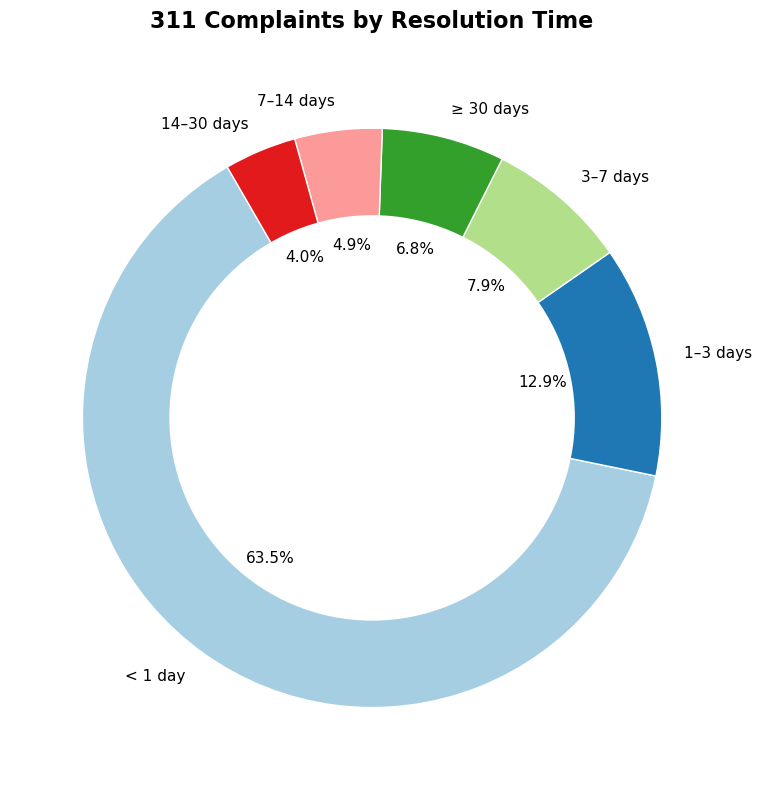

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Run your SQL query
query = """
WITH complaints_num AS (
  SELECT
    c.complaint_id,
    TRY_CAST(
      NULLIF(REGEXP_REPLACE(CAST(c.duration_hours AS VARCHAR), '[^0-9.\\-]', ''), '')
      AS DECIMAL(18,2)
    ) AS duration_hours_num
  FROM public.fact_311_complaint c
)
SELECT
  CASE
    WHEN duration_hours_num IS NULL         THEN 'Unknown'
    WHEN duration_hours_num < 24            THEN '< 1 day'
    WHEN duration_hours_num < 72            THEN '1–3 days'
    WHEN duration_hours_num < 168           THEN '3–7 days'
    WHEN duration_hours_num < 336           THEN '7–14 days'
    WHEN duration_hours_num < 720           THEN '14–30 days'
    ELSE '≥ 30 days'
  END AS resolution_bucket,
  COUNT(*) AS complaints
FROM complaints_num
WHERE duration_hours_num IS NOT NULL
GROUP BY 1
ORDER BY complaints DESC;
"""

# Read the data into a pandas DataFrame
df = pd.read_sql(query, conn)
print(df)

# ---------------------------
# Create a colorful pie chart
# ---------------------------

# Define labels and sizes
labels = df["resolution_bucket"]
sizes = df["complaints"]

# Pick a color palette
colors = plt.cm.Paired(range(len(labels)))  # e.g., Paired, Set3, tab20c

# Create figure
fig, ax = plt.subplots(figsize=(8, 8))

# Make the pie chart
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct="%1.1f%%",
    startangle=120,
    textprops={"color": "black", "fontsize": 11},
    wedgeprops={"edgecolor": "white"}
)

# Add title and styling
ax.set_title("311 Complaints by Resolution Time", fontsize=16, fontweight="bold", pad=20)
plt.tight_layout()

# Optional: make it a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)

# Show the pie chart
plt.show()

# ---------------------------
# Optional: Save the figure
# ---------------------------
# fig.savefig("complaint_resolution_pie.png", dpi=300, bbox_inches="tight")


/tmp/ipykernel_13939/1486486435.py:23: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



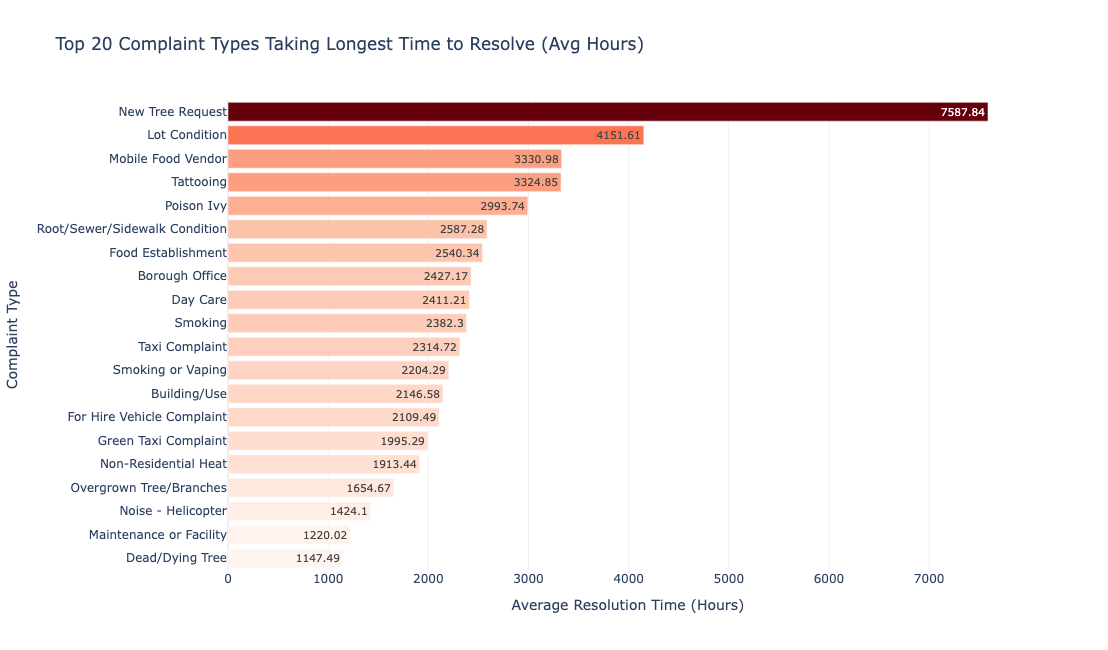

/tmp/ipykernel_13939/1486486435.py:76: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



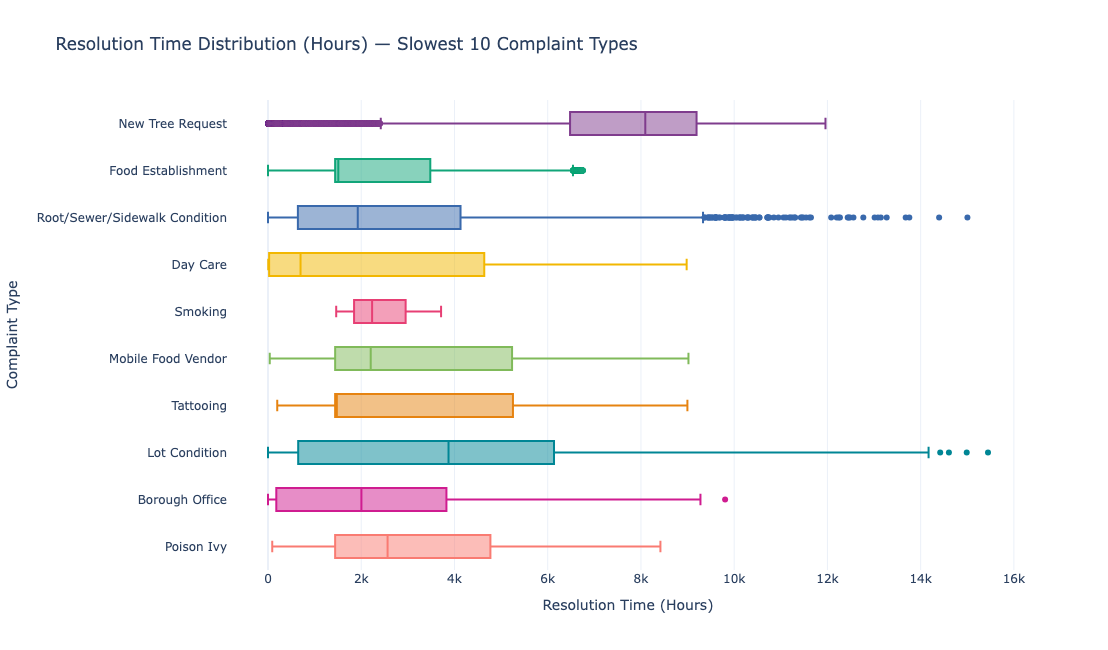

In [64]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

sql = """
SELECT
    c.complaint_type,
    COUNT(*) AS total_complaints,
    ROUND(AVG(TRY_CAST(f.duration_hours AS DECIMAL(10,2))), 2) AS avg_resolution_hours,
    ROUND(AVG(TRY_CAST(f.duration_hours AS DECIMAL(10,2))) / 24, 1) AS avg_resolution_days,
    MAX(TRY_CAST(f.duration_hours AS DECIMAL(10,2))) AS max_resolution_hours,
    MIN(TRY_CAST(f.duration_hours AS DECIMAL(10,2))) AS min_resolution_hours
FROM public.fact_311_complaint f
JOIN public.dim_311_complaint c 
  ON f.complaint_type_key = c.complaint_type_key
WHERE TRY_CAST(f.duration_hours AS DECIMAL(10,2)) IS NOT NULL
GROUP BY c.complaint_type
HAVING COUNT(*) > 50  -- ignore rare complaint types
ORDER BY avg_resolution_hours DESC
LIMIT 20;  -- top 20 slowest complaint types
"""

df = pd.read_sql(sql, conn)

# Ensure numeric columns are correct
num_cols = ["avg_resolution_hours","avg_resolution_days",
            "max_resolution_hours","min_resolution_hours","total_complaints"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# --------------------------------------------------------------------------
# 2️⃣  Horizontal bar chart — complaint types taking longest time
# --------------------------------------------------------------------------
fig_bar = px.bar(
    df.sort_values("avg_resolution_hours", ascending=True),
    x="avg_resolution_hours",
    y="complaint_type",
    orientation="h",
    text="avg_resolution_hours",
    color="avg_resolution_hours",
    color_continuous_scale="Reds",
    title="Top 20 Complaint Types Taking Longest Time to Resolve (Avg Hours)"
)
fig_bar.update_layout(
    template="plotly_white",
    xaxis_title="Average Resolution Time (Hours)",
    yaxis_title="Complaint Type",
    coloraxis_showscale=False,
    height=650
)
fig_bar.show()

# --------------------------------------------------------------------------
# 3️⃣  Optional: Box plot — variation in resolution time by type
#      (useful if you want to see spread/outliers)
# --------------------------------------------------------------------------
sql_box = """
SELECT
    c.complaint_type,
    TRY_CAST(f.duration_hours AS DECIMAL(10,2)) AS duration_hours
FROM public.fact_311_complaint f
JOIN public.dim_311_complaint c 
  ON f.complaint_type_key = c.complaint_type_key
WHERE TRY_CAST(f.duration_hours AS DECIMAL(10,2)) IS NOT NULL
  AND c.complaint_type IN (
      SELECT complaint_type
      FROM public.dim_311_complaint c2
      JOIN public.fact_311_complaint f2 ON c2.complaint_type_key = f2.complaint_type_key
      WHERE TRY_CAST(f2.duration_hours AS DECIMAL(10,2)) IS NOT NULL
      GROUP BY complaint_type
      HAVING COUNT(*) > 50
      ORDER BY AVG(TRY_CAST(f2.duration_hours AS DECIMAL(10,2))) DESC
      LIMIT 10
  );
"""
df_box = pd.read_sql(sql_box, conn)
df_box["duration_hours"] = pd.to_numeric(df_box["duration_hours"], errors="coerce")

fig_box = px.box(
    df_box,
    x="duration_hours",
    y="complaint_type",
    color="complaint_type",
    title="Resolution Time Distribution (Hours) — Slowest 10 Complaint Types",
    color_discrete_sequence=px.colors.qualitative.Bold,
)
fig_box.update_layout(
    template="plotly_white",
    xaxis_title="Resolution Time (Hours)",
    yaxis_title="Complaint Type",
    showlegend=False,
    height=650
)
fig_box.show()
